# Tarea 2 - Deep Learning

## Alumno: Amadeo Gustavo Ancarani

### Tarea Planteada:

* Con el Dataset de series temporales generado sintéticamente en el notebook '4_componentes_red_neuronal':
  * Diseñar una red recurrente que prediga si va a subir o bajar y cuánto (Pista, hay que usar una custom loss).

##### 00 - Importo las librerias

In [1]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.callbacks import LearningRateScheduler
import tensorflow as tf
from tensorflow.keras import backend as K


def show_history(history, metrics=['accuracy']):
    """
    Visualize history
    :param history:
    :return:
    """

    # Plot history: Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss history')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    for metric in metrics:
        # Plot history:
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.title(metric + ' history')
        plt.ylabel(metric + ' value (%)')
        plt.xlabel('No. epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()


def step_decay(epochs_drop):
    def step_decay_fun(epoch):
        initial_lrate = 0.001
        drop = 0.000001
        lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((1+epoch)/epochs_drop))
        return lrate
    return step_decay_fun


def r2_keras(y_true, y_pred):
    """
    Custom R2-score metrics for keras backend
    :param y_true: valor real
    :type y_true: Tensor
    :param y_pred: valor predicho
    :type y_pred: Tensor
    :return: r2 score
    :rtype: tensor
    """
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import LSTM
import random
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import mean_absolute_percentage_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import BatchNormalization

# 01 - Creo el Dataset sintético

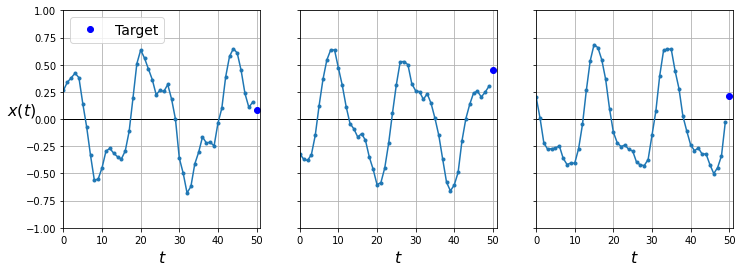

In [3]:
random.seed(1)
# Esta función genera una serie temporal seudo aleatoria con cierta periodicidad
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# Generamos train, validation y test y 10k gráficas mediante las dos series temporales y el ruido de arriba
n_steps = 50 #50 valores de la serie dados y predecir el siguiente
series = generate_time_series(10000, n_steps + 1)
X_train_sequence, y_train_sequence = series[:7000, :n_steps], series[:7000, -1]
X_valid_sequence, y_valid_sequence = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test_sequence, y_test_sequence = series[9000:, :n_steps], series[9000:, -1]


# Función para plotear
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid_sequence[col, :, 0], y_valid_sequence[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [4]:
y_train_sequence

array([[-0.2868816 ],
       [-0.2293541 ],
       [-0.5257046 ],
       ...,
       [-0.4721484 ],
       [ 0.01921542],
       [-0.04879145]], dtype=float32)

In [5]:
#y_train_sequence = list(y_train_sequence)
d = []
for i in range(0,len(y_train_sequence)):
  d.append((y_train_sequence[i] >= 0)*1)

y_train_class = np.array(d)

d = []
for i in range(0,len(y_valid_sequence)):
  d.append((y_valid_sequence[i] >= 0)*1)

y_valid_class = np.array(d)

d = []
for i in range(0,len(y_test_sequence)):
  d.append((y_test_sequence[i] >= 0)*1)

y_test_class = np.array(d)

# 02 - Creo el modelo aplicando una loss por separado

In [6]:
input_tensor = Input(shape=(n_steps), dtype='float32')
x_0 = input_tensor
x = tf.expand_dims(x_0, axis=-1)

# Dependiendo de cual sea el output deberemos cambiar el valor 'return_sequences'
for _ in range(5):
    x = LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
x = LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(100, activation=tf.nn.leaky_relu)(x)
#x = layers.Dense(1, activation=None)(x)

# regression output
out_reg = layers.Dense(1, activation='linear')(x)

# classification output
n_class = 2
out_clas = layers.Dense(n_class, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=[out_reg, out_clas])
print(model.summary())

# construimos una función loss que es una suma del R2 y 
def custom_loss(alpha):
    def custom_loss_fun(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return r2_keras(y_true[0], y_pred[0]) + bce(y_true[1], y_pred[1]) * alpha
    return custom_loss_fun

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=['mse','sparse_categorical_crossentropy'] , metrics=['mean_absolute_error', 'accuracy'])


history = model.fit(X_train_sequence,[y_train_sequence, y_train_class], epochs=20, batch_size=30, steps_per_epoch=200, verbose=1, validation_data=(X_valid_sequence, 
                                                                                                                                                   ),validation_steps=10)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 50, 1)        0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 50, 100)      40800       ['tf.expand_dims[0][0]']         
                                                                                                  
 lstm_1 (LSTM)                  (None, 50, 100)      80400       ['lstm[0][0]']                   
                                                                                              

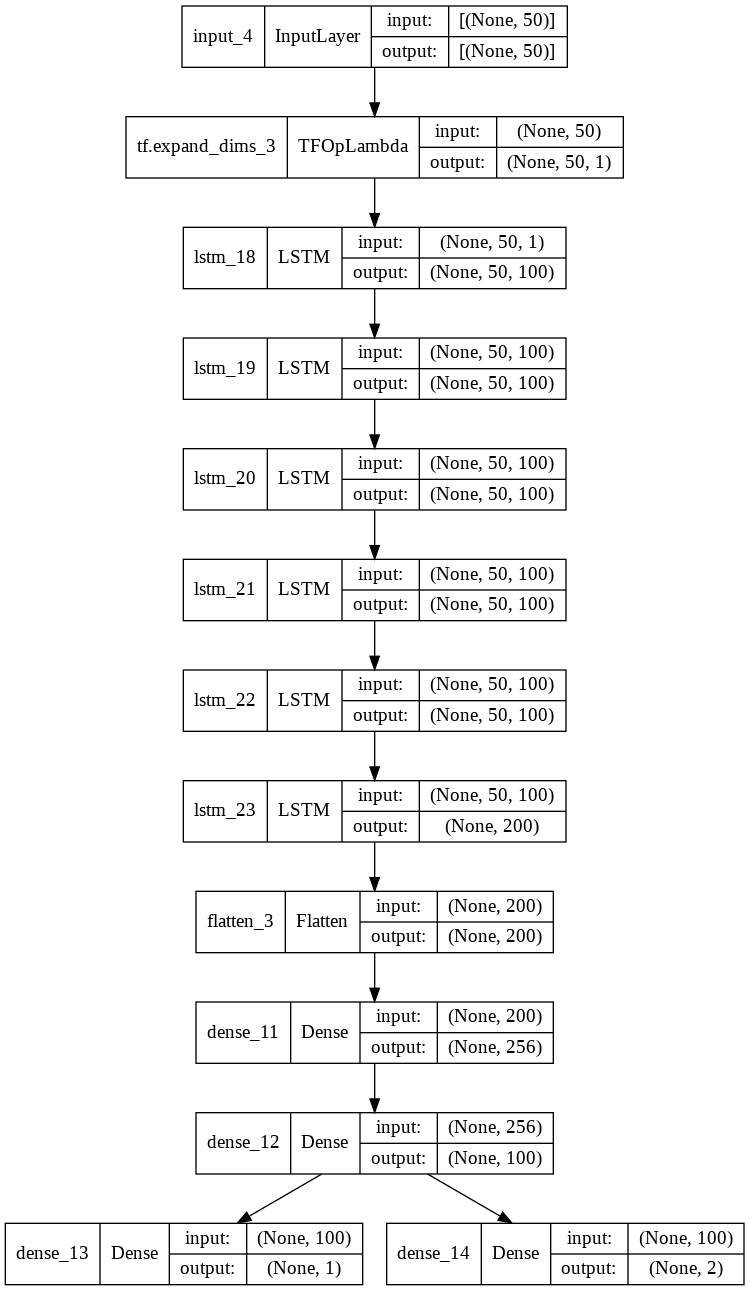

In [40]:
plot_model(model, show_shapes=True)

In [7]:
yhat1, yhat2 = model.predict(X_test_sequence)
# calculate error for regression model
error = mean_absolute_error(y_test_sequence, yhat1)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = np.argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class, yhat2)
print('Accuracy: %.3f' % acc)

MAE: 0.049
Accuracy: 0.969


Da muy buenos resultados

# 03 Creo un modelo con una custom loss 

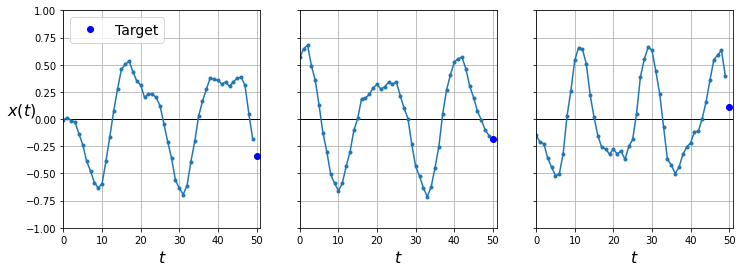

In [3]:
random.seed(1)
# Esta función genera una serie temporal seudo aleatoria con cierta periodicidad
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# Generamos train, validation y test y 10k gráficas mediante las dos series temporales y el ruido de arriba
n_steps = 50 #50 valores de la serie dados y predecir el siguiente
series = generate_time_series(10000, n_steps + 1)
X_train_sequence, y_train_sequence = series[:7000, :n_steps], series[:7000, -1]
X_valid_sequence, y_valid_sequence = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test_sequence, y_test_sequence = series[9000:, :n_steps], series[9000:, -1]


# Función para plotear
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid_sequence[col, :, 0], y_valid_sequence[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [4]:
#y_train_sequence = list(y_train_sequence)
d = []
for i in range(0,len(y_train_sequence)):
  d.append([y_train_sequence[i], (y_train_sequence[i] >= 0)*1])

y_train_class = np.array(d)
y_train_class = y_train_class[:,:,0]

d = []
for i in range(0,len(y_valid_sequence)):
  d.append([y_valid_sequence[i], (y_valid_sequence[i] >= 0)*1])

y_valid_class = np.array(d)
y_valid_class = y_valid_class[:,:,0]

d = []
for i in range(0,len(y_test_sequence)):
  d.append([y_test_sequence[i], (y_test_sequence[i] >= 0)*1])

y_test_class = np.array(d)
y_test_class = y_test_class[:,:,0]

In [10]:
y_test_class.shape

(1000, 2)

In [32]:
y_test_class[1,:]

array([-0.04203208,  0.        ])

In [11]:
X_test_sequence.shape

(1000, 50, 1)

In [5]:
input_tensor = Input(shape=(n_steps), dtype='float32')
x_0 = input_tensor
x = tf.expand_dims(x_0, axis=-1)

# Dependiendo de cual sea el output deberemos cambiar el valor 'return_sequences'
for _ in range(5):
    x = LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
x = LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(x)

x = layers.Flatten()(x)
x = layers.Dense(250, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(500, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(2, activation=None)(x)

model = Model(inputs=input_tensor, outputs=x)
print(model.summary())

# construimos una función loss que es una suma del R2 y 
def custom_loss(alpha):
    def custom_loss_fun(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return mean_absolute_percentage_error(y_true[:,0], y_pred[:,0]) + (bce(y_true[:,1], y_pred[:,1]) * alpha)
    return custom_loss_fun

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=custom_loss(5) , metrics=[RootMeanSquaredError(), 'accuracy'])


history = model.fit(X_train_sequence, y_train_class, epochs=20, batch_size=30, 
                    steps_per_epoch=200, verbose=1, validation_data=(X_valid_sequence, y_valid_class),
                    validation_steps=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 50, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_3 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_4 (LSTM)               (None, 50, 100)           80400 

In [6]:
yhat1 = model.predict(X_test_sequence)
d = []

for i in range(0, len(y_test_sequence)):
  d.append(yhat1[i,0])

yhat_reg = np.array(d)

d = []

for i in range(0, len(y_test_sequence)):
  d.append([yhat1[i,1]])

yhat_class = np.array(d)

In [18]:
# calculate error for regression model
error = mean_absolute_error(y_test_sequence, yhat_reg)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = np.round(yhat_class,0).astype('int')#, axis=-1).astype('int')
acc = accuracy_score(y_test_class[:,1], yhat2)
print('Accuracy: %.3f' % acc)

MAE: 0.325
Accuracy: 0.476


Los resultados no son muy buenos, ajustaré el alpha

# 04 Modelo Custom Loss 2

In [19]:
input_tensor = Input(shape=(n_steps), dtype='float32')
x_0 = input_tensor
x = tf.expand_dims(x_0, axis=-1)

# Dependiendo de cual sea el output deberemos cambiar el valor 'return_sequences'
for _ in range(5):
    x = LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
x = LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(x)

x = layers.Flatten()(x)
x = layers.Dense(250, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(500, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(2, activation=None)(x)

model = Model(inputs=input_tensor, outputs=x)
print(model.summary())

# construimos una función loss que es una suma del R2 y 
def custom_loss(alpha):
    def custom_loss_fun(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return mean_absolute_percentage_error(y_true[:,0], y_pred[:,0]) + (bce(y_true[:,1], y_pred[:,1]) * alpha)
    return custom_loss_fun

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=custom_loss(0.00000000001) , metrics=[RootMeanSquaredError(), 'accuracy'])


history = model.fit(X_train_sequence, y_train_class, epochs=20, batch_size=30, 
                    steps_per_epoch=200, verbose=1, validation_data=(X_valid_sequence, y_valid_class),
                    validation_steps=10)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 50, 1)            0         
 a)                                                              
                                                                 
 lstm_6 (LSTM)               (None, 50, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_8 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_9 (LSTM)               (None, 50, 100)           80400     
                                                           

In [20]:
yhat1 = model.predict(X_test_sequence)
d = []

for i in range(0, len(y_test_sequence)):
  d.append(yhat1[i,0])

yhat_reg = np.array(d)

d = []

for i in range(0, len(y_test_sequence)):
  d.append([yhat1[i,1]])

yhat_class = np.array(d)

# calculate error for regression model
error = mean_absolute_error(y_test_sequence, yhat_reg)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = np.round(yhat_class,0).astype('int')#, axis=-1).astype('int')
acc = accuracy_score(y_test_class[:,1], yhat2)
print('Accuracy: %.3f' % acc)

MAE: 0.325
Accuracy: 0.476


Los resultados no son muy buenos tampoco, re-ajustaré el alpha

# 05 Modelo Custom Loss 3

In [21]:
input_tensor = Input(shape=(n_steps), dtype='float32')
x_0 = input_tensor
x = tf.expand_dims(x_0, axis=-1)

# Dependiendo de cual sea el output deberemos cambiar el valor 'return_sequences'
for _ in range(10):
    x = LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
x = LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(x)

x = layers.Flatten()(x)
x = layers.Dense(250, activation=tf.nn.leaky_relu)(x)
x = BatchNormalization()(x)
x = layers.Dense(500, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(2, activation=None)(x)

model = Model(inputs=input_tensor, outputs=x)
print(model.summary())

# construimos una función loss que es una suma del R2 y 
def custom_loss(alpha):
    def custom_loss_fun(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return mean_absolute_percentage_error(y_true[:,0], y_pred[:,0]) + (bce(y_true[:,1], y_pred[:,1]) * alpha)
    return custom_loss_fun

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=custom_loss(0.0001) , metrics=[RootMeanSquaredError(), 'accuracy'])


history = model.fit(X_train_sequence, y_train_class, epochs=20, batch_size=30, 
                    steps_per_epoch=200, verbose=1, validation_data=(X_valid_sequence, y_valid_class),
                    validation_steps=10)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 50, 1)            0         
 a)                                                              
                                                                 
 lstm_12 (LSTM)              (None, 50, 100)           40800     
                                                                 
 lstm_13 (LSTM)              (None, 50, 100)           80400     
                                                                 
 lstm_14 (LSTM)              (None, 50, 100)           80400     
                                                                 
 lstm_15 (LSTM)              (None, 50, 100)           80400     
                                                           

In [22]:
yhat1 = model.predict(X_test_sequence)
d = []

for i in range(0, len(y_test_sequence)):
  d.append(yhat1[i,0])

yhat_reg = np.array(d)

d = []

for i in range(0, len(y_test_sequence)):
  d.append([yhat1[i,1]])

yhat_class = np.array(d)

# calculate error for regression model
error = mean_absolute_error(y_test_sequence, yhat_reg)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = np.round(yhat_class,0).astype('int')#, axis=-1).astype('int')
acc = accuracy_score(y_test_class[:,1], yhat2)
print('Accuracy: %.3f' % acc)

MAE: 0.326
Accuracy: 0.476


Los resultados no son muy buenos tampoco, re-ajustaré el alpha

# 06 Modelo Custom Loss 4

In [23]:
input_tensor = Input(shape=(n_steps), dtype='float32')
x_0 = input_tensor
x = tf.expand_dims(x_0, axis=-1)

# Dependiendo de cual sea el output deberemos cambiar el valor 'return_sequences'
for _ in range(10):
    x = LSTM(100, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(x)
x = LSTM(200, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(x)

x = layers.Flatten()(x)
x = layers.Dense(250, activation=tf.nn.leaky_relu)(x)
x = BatchNormalization()(x)
x = layers.Dense(500, activation=tf.nn.leaky_relu)(x)
x = layers.Dense(2, activation=None)(x)

model = Model(inputs=input_tensor, outputs=x)
print(model.summary())

# construimos una función loss que es una suma del R2 y 
def custom_loss(alpha):
    def custom_loss_fun(y_true, y_pred):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        return mean_absolute_percentage_error(y_true[:,0], y_pred[:,0]) * 100 + (bce(y_true[:,1], y_pred[:,1]) * alpha)
    return custom_loss_fun

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=custom_loss(0.0001) , metrics=[RootMeanSquaredError(), 'accuracy'])


history = model.fit(X_train_sequence, y_train_class, epochs=20, batch_size=30, 
                    steps_per_epoch=200, verbose=1, validation_data=(X_valid_sequence, y_valid_class),
                    validation_steps=10)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 tf.expand_dims_3 (TFOpLambd  (None, 50, 1)            0         
 a)                                                              
                                                                 
 lstm_23 (LSTM)              (None, 50, 100)           40800     
                                                                 
 lstm_24 (LSTM)              (None, 50, 100)           80400     
                                                                 
 lstm_25 (LSTM)              (None, 50, 100)           80400     
                                                                 
 lstm_26 (LSTM)              (None, 50, 100)           80400     
                                                           

In [24]:
yhat1 = model.predict(X_test_sequence)
d = []

for i in range(0, len(y_test_sequence)):
  d.append(yhat1[i,0])

yhat_reg = np.array(d)

d = []

for i in range(0, len(y_test_sequence)):
  d.append([yhat1[i,1]])

yhat_class = np.array(d)

# calculate error for regression model
error = mean_absolute_error(y_test_sequence, yhat_reg)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = np.round(yhat_class,0).astype('int')#, axis=-1).astype('int')
acc = accuracy_score(y_test_class[:,1], yhat2)
print('Accuracy: %.3f' % acc)

MAE: 0.325
Accuracy: 0.476


No hemos logrado obtener valores consistentes a lo largo de la implementacion de la custom loss, sin embargo al separar los outputs, logramos resultados muy buenos.